# Customer Churn Modeling using Baseline Model

We use a small dataset created based on statistics from a digital media company that sells services on a subscription basis
The dataset includes about 9,000 customer profiles with the daily service usage data.
Half of the profiles are churners and the other half are not churners.

In [ ]:
#importing the libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from tabulate import tabulate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, LSTM, Input, Concatenate
from tensorflow.keras.layers import Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from tensorflow.keras import backend as K

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_style("whitegrid")

In [8]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_style("whitegrid")

In [9]:
def print_df(df):
    print(tabulate(df.head(10), headers='keys', tablefmt='psql'))
    print(f'{len(df)} rows x {len(df.columns)} columns')
    
def plot_roc(y_test, y_hat_prob):
    plt.figure(figsize=(8, 8))
    false_positive_rate, recall, thresholds = roc_curve(y_test, y_hat_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'r', label = 'AUC = %0.3f' % roc_auc)
    plt.fill_between(false_positive_rate, recall, color='r', alpha=0.025)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1 - Specificity)')
    plt.savefig('roc.pdf')
    plt.show()
    
def plot_confusion_matrix(y, y_hat_prob, labels):
    y_hat = np.where(y_hat_prob > 0.5, 1, 0) # probability to 0-1 binary
    cm = confusion_matrix(y, y_hat)
    accuracy = accuracy_score(y, y_hat)
    plt.figure(figsize=(4, 4));
    sns.heatmap(cm, xticklabels = labels, yticklabels = labels, 
                annot = True, cbar=False, fmt='d', annot_kws={'size': 16}, 
                cmap="Wistia", vmin = 0.2);
    plt.title(f'Confusion Matrix\n({len(y)} samples, accuracy {accuracy:.3f})')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.savefig('confusion.pdf')
    plt.show()

In [27]:
data_path = '../../tensor-house-data/promotions/churn-media-data/'
df_users = pd.read_csv('C:/Users/pooja/Downloads/users.csv.zip', compression='zip', index_col='uid', parse_dates=['registration_date'])
df_logs = pd.read_csv('C:/Users/pooja/Downloads/usage_logs.csv.zip', compression='zip', index_col='uid', parse_dates=['date']).drop(columns=['items'])

print_df(df_users)
print_df(df_logs)
n_churners = df_users['is_churn'].sum()
print(f"Churners: {n_churners} ({n_churners/len(df_users):.2%})")
print(f"Users without events: {len(set(df_users.index).difference(set(df_logs.index)))}")

+-------+------------+-------+----------+------------------------+---------------------+------------+
|   uid |   location |   age | gender   |   registration_channel | registration_date   |   is_churn |
|-------+------------+-------+----------+------------------------+---------------------+------------|
|     0 |         15 |    17 | female   |                      3 | 2014-10-21 00:00:00 |          1 |
|     1 |         13 |    40 | female   |                      9 | 2006-05-26 00:00:00 |          0 |
|     2 |         14 |    23 | male     |                      9 | 2007-03-25 00:00:00 |          1 |
|     3 |          1 |    19 | female   |                      3 | 2014-11-02 00:00:00 |          1 |
|     4 |          1 |     0 | nan      |                      9 | 2014-11-08 00:00:00 |          1 |
|     5 |         21 |    21 | male     |                      9 | 2007-10-12 00:00:00 |          1 |
|     6 |          1 |     0 | nan      |                      7 | 2014-04-16 00:0

In [29]:
#
# Feature engineerign for LightGBM
#
profiles = df_users.join(df_logs.drop(columns='date').groupby('uid').agg('sum'), on='uid')
profiles['reg_days'] = (profiles['registration_date'].max() - profiles['registration_date']).dt.days
profiles = pd.get_dummies(profiles, columns=['gender'])
profiles.drop(columns=['registration_date'], inplace=True)
print_df(profiles)

+-------+------------+-------+------------------------+------------+---------+------------------+------------+------------+-----------------+---------------+
|   uid |   location |   age |   registration_channel |   is_churn |   views |         duration |   previews |   reg_days |   gender_female |   gender_male |
|-------+------------+-------+------------------------+------------+---------+------------------+------------+------------+-----------------+---------------|
|     0 |         15 |    17 |                      3 |          1 |    2634 | 883533           |       4544 |        856 |               1 |             0 |
|     1 |         13 |    40 |                      9 |          0 |   22987 |      6.46504e+06 |       7135 |       3926 |               1 |             0 |
|     2 |         14 |    23 |                      9 |          1 |   52439 |      1.35129e+07 |       4897 |       3623 |               0 |             1 |
|     3 |          1 |    19 |                      

In [30]:
# Train test split
#
x, y = profiles.drop(columns='is_churn'), profiles['is_churn']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [31]:
train_data = lgb.Dataset(x_train, label=y_train)

# Model hyper-parameters
params = {'max_depth' : -1,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'num_class' : 1,
          'metric' : 'binary_error'
          }

# Parameters to tune
gridParams = {
    'learning_rate': [0.02, 0.05, 0.07],
    'n_estimators': [8, 16, 32, 64, 128],
    'num_leaves': [20, 24, 28],
    'colsample_bytree' : [0.60, 0.65]
    }

# Create the classifier
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'])

mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)

# Search for optimal parameters
grid.fit(x_train, y_train)

# Print the best parameters values
print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
params['num_leaves'] = grid.best_params_['num_leaves']
params['n_estimators'] = grid.best_params_['n_estimators']

print(f'Fitting with params: {params}')

# Train the model on the selected parameters
lgbm = lgb.train(params,
                 train_data,
                 num_boost_round=200,
                 verbose_eval= 4)


Fitting 4 folds for each of 90 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   27.7s finished


Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.07, 'n_estimators': 64, 'num_leaves': 20}
Best score: 0.6982520820895838
Fitting with params: {'max_depth': -1, 'num_leaves': 20, 'learning_rate': 0.07, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1, 'colsample_bytree': 0.6, 'num_class': 1, 'metric': 'binary_error', 'n_estimators': 64}
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 6734, number of used features: 9
[LightGBM] [Info] Start training from score 0.504455


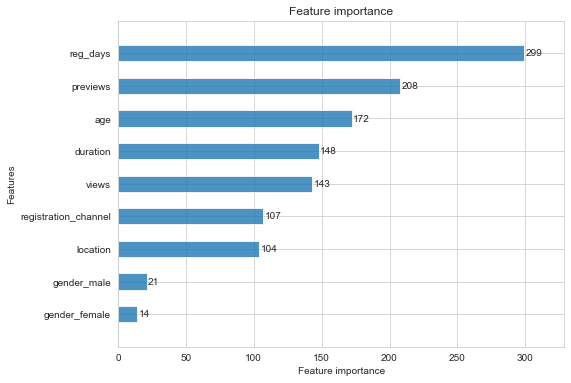

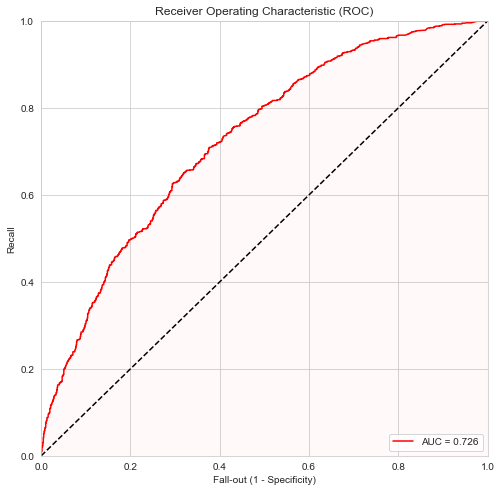

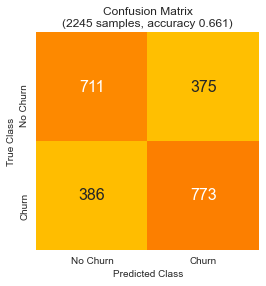

In [32]:
# 
# Plot accuracy measures and diagnostic information
#

# Predict on test set
predictions_lgbm_prob = lgbm.predict(x_test)

# Plot feature importances
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split',
                    height=0.5, color='#1f77b4', alpha=0.8, figsize=(8, 6))

# plot ROC
plot_roc(y_test, predictions_lgbm_prob)

# plot confusion matrix
plot_confusion_matrix(y_test, predictions_lgbm_prob, ['No Churn', 'Churn'])